In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# read all the words
words = open('names.txt', 'r').read().splitlines()

In [8]:
# buld the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [68]:
# build the datasets
# 80% - training split
# 10% - validation/dev split -> use this to try differnt things with hyper-parameters (like No. of layers, sizes and so on)
# 10% - test split
def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append (rolling window)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [69]:
C = torch.randn((27, 2)) # each one of 27 chars has a two dimensional embedding

In [74]:
g = torch.Generator().manual_seed(2147483647)
# input layer
C = torch.randn((27, 10), generator=g)
# tanh layer
W1 = torch.randn((30, 200), generator=g) # we have 3x10 inputs = 30 inputs, and use 200 neurons
b1 = torch.randn(200, generator=g)      # create a random bias for 200 neurons
# final layer: probabilities with softmax
W2 = torch.randn(200, 27, generator=g)  # 200 inputs, 27 neurons output for 27 characters that could come next
b2 = torch.randn(27, generator=g)       # aligned to 27 neurons
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # numbers of parameters in total

11897

In [75]:
lri = []
lossi = []
stepi = []

In [87]:
for i in range(50000):

    # only train on a subset of the data (e.g. 32 random examples)
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # embeds X (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # contents of neurons layer 1 (32, 100)
    logits = h @ W2 + b2                      # contents of neuron layer 2 (32, 27)

    # this full block can be done by pytorch
    #counts = logits.exp()                     # softmax
    #prob = counts / counts.sum(1, keepdim=True)
    #loss = -prob[torch.arange(32), Y].log().mean() # neg. log likelihood
    loss = F.cross_entropy(logits, Ytr[ix]) # this is better, more efficient, and has less side-effects (e.g. handles extreme values)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    lr = 0.01 # 1.0 --> learning rate decay to get closer to best value
    for p in parameters:
        p.data += -lr * p.grad # play with the learning rate to make sure it constantly decreases without jumps

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # log-loss instead of loss

# loss of this iteration
# print(loss.item())


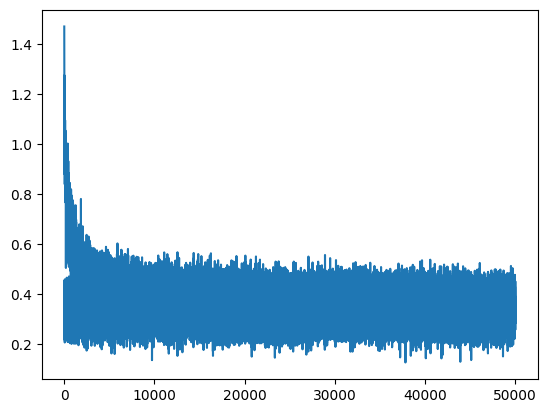

In [88]:
plt.plot(stepi, lossi)

In [89]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
# loss of dev dataset
loss

tensor(2.1936, grad_fn=<NllLossBackward0>)

In [90]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
# loss of training dataset
loss

tensor(2.1693, grad_fn=<NllLossBackward0>)

In [ ]:
# dev and training have more or less the same loss
# so we are not overfitting, but underfitting
# we can make the network bigger (more neurons 100->300)

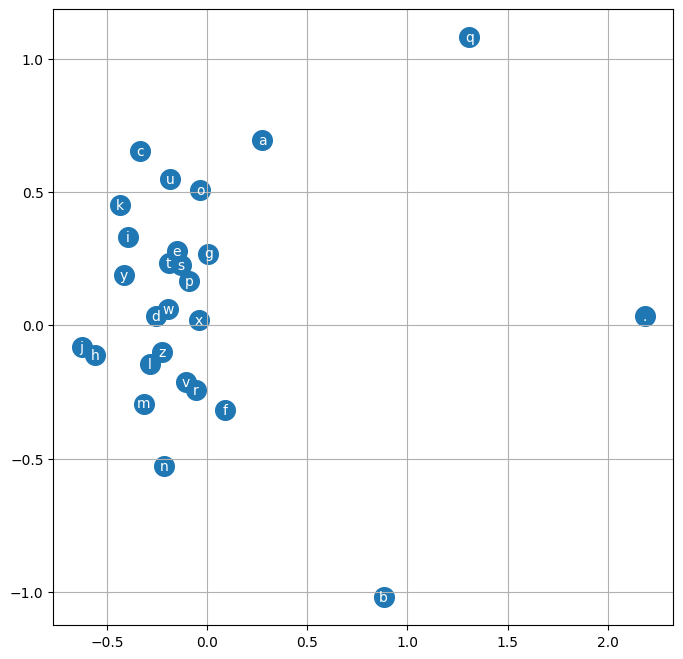

In [91]:
# visualize the embeddings
# this will show what the network learned
# e.g. aeiou are more similar
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [95]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3 # context length

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))
    

carlah.
amelle.
khi.
mrichelly.
sachasne.
mahnen.
ameryn.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
prin.
quint.
shornea.
jadiq.
watelo.
dearyxi.
fine.
pirsan.
